# Patially Linear Regression models using Double Machine Learning

Version without lagged demand

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api
import statsmodels
from sklearn.base import clone
import doubleml as dml
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, Lasso
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

In [2]:
#import transformed dataset that's ready for use
df_log=pd.read_csv("dataframe_transformed_4_log.csv")

In [3]:
#Some additional transformations:

# The zero demand observations become -infinity because of the log-transformation
# These values should be deleted or replaced:
    # the observations with zero demand will be deleted, however in the lagged demand variable this data is still needed
    # So choose a value to impute these -infinity values with: Preferably np.NaN such that no bias will occur

# Based on what first stage method you will use, it may or may not be able to handle missing values. 
# Create an imputed value for the methods that cannot use NaNs
# Here: the missing values are most often referring to a promo period, hence a MAX value for demand is imputed to act as a surrogate for this promo demand.

# Include dummy variab;e for holidays and other special dates that can explain irregular demand
listofHolidays=["2020-12-28",
                "2021-01-04",
                "2021-03-29",
                "2021-05-03",
                "2021-07-26",
                "2021-08-02",
                "2021-08-09",
                "2021-08-16",
                "2021-12-27",
                "2022-01-03",
                "2022-04-11",
                "2022-05-02",
                "2022-07-25",
                "2022-08-01",
                "2022-08-08",
                "2022-08-15",
                "2022-12-26"
                ]
df_log['HOLIDAY']=(df_log['WEEK_START_DATE'].isin(listofHolidays))*1

# non-log-transformed week number (do not need log-interpretatation of this variable ("percentage increase in week number leads to percentage change in demand or price" --> should be "absolute change in weeks lead to percentage change demand/price")
# (inflation measure)
df_log['WEEK_NR']=np.round(np.exp(df_log['L_WEEK_NR']))

Model set up: create datasets


In [4]:
x_lasso= df_log[['CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 
       'PROMO_DUMMY', 
       'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2','POSTPPL3', 
       'L_AVG_HIGH_TEMP',#'L_TOTAL_ORDER_AMT',
       'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2', # 'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       
       'HOLIDAY','WEEK_NR'
       ]]
y_lasso = df_log['L_PRODUCT_ORDER_AMT']
p_lasso = df_log['L_AVG_SELL_PRICE']
dmlset_lasso=x_lasso.join(y_lasso.to_frame().join(p_lasso.to_frame())) #needed in dml algortihm

In [5]:
x_lasso_train, x_lasso_test, y_lasso_train, y_lasso_test, p_lasso_train, p_lasso_test,dmlset_lasso_train,dmlset_lasso_test = train_test_split(x_lasso,y_lasso,p_lasso,dmlset_lasso,random_state=44)

DML Part - OLS second stage - PLR

# Using Lasso first stage


Using Lasso 1st stage - LassoCV instead of Lasso to get optimized alpha value

In [6]:
# The actual model:
# need a defined version of ml_l_tune and ml_r_tune for this (defined a few cells above)
ml_l_tune = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,y_lasso_train)
ml_r_tune = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,p_lasso_train)

# Create correctly formatted data object based on dml package and DoubleMLData functionality
obj_dml_data = dml.DoubleMLData(dmlset_lasso_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE')

# Use data object, defined first stages, number of cross-fitting splits (n_folds)
dml_pliv_obj = dml.DoubleMLPLR(obj_dml_data, ml_l_tune, ml_r_tune, n_folds=5) 

#Print output
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): None
No. Observations: 50933

------------------ Score & algorithm ------------------
Score functi

Additional first stage model insight:

In [9]:
# Fit the first stage models
ml_l_tune = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,y_lasso_train)
ml_r_tune = LassoCV(fit_intercept=True, cv=10).fit(x_lasso_train,p_lasso_train)
print("Optimal alpha l (for Y):", ml_l_tune.alpha_,"converged in:", ml_l_tune.n_iter_, "iterations; ",
"\nOptimal alpha r (for P):", ml_r_tune.alpha_,"converged in:", ml_r_tune.n_iter_ ,"iterations" )

# To judge quality of first stage
y_pred_L=ml_l_tune.predict(x_lasso_test)
p_pred_R=ml_r_tune.predict(x_lasso_test)
# Calculate and print the root mean squared error
print("RMSE l(X): ",mean_squared_error(y_lasso_test, y_pred_L,squared=True), "RMSE r(X):",mean_squared_error(p_lasso_test, p_pred_R,squared=True))

Optimal alpha l (for Y): 0.23469580514336075 converged in: 3 iterations;  
Optimal alpha r (for P): 0.06328520821379979 converged in: 13 iterations
RMSE l(X):  1.7260267495400416 RMSE r(X): 0.19804752288514663


In [10]:
# Get residualized vars for analysis (will be calculated also in model)
y_res_lasso=y_lasso_test-y_pred_L
p_res_lasso=p_lasso_test-p_pred_R

#get dataframe of test set only (for analysis also)
testdf=df_log.iloc[p_res_lasso.reset_index()['index'],:]
# add residualized variables to test set such that you can compare them with different feature values (to check for correlations)
testdf['y_res_lasso'] =y_res_lasso
testdf['p_res_lasso']=p_res_lasso

C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_10684\1843049202.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['y_res_lasso'] =y_res_lasso
C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_10684\1843049202.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['p_res_lasso']=p_res_lasso


c:\Apps\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Apps\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='WEEK_NR', ylabel='y_res_lasso'>

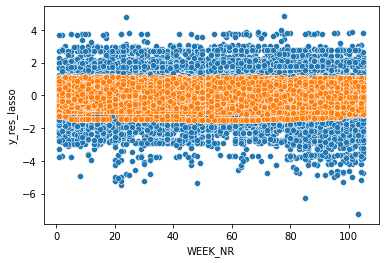

In [11]:
# analyse if there is a pattern over time in the quality of predictions: 
# intuition is to see whether inflation/time effect is captured correctly

sns.scatterplot(testdf['WEEK_NR'],testdf['y_res_lasso'])
sns.scatterplot(testdf['WEEK_NR'],testdf['p_res_lasso'])

# Using RFor 1st stage - hyperparameters optimized on model with 2sls as 2nd stage (drinks set)

In [12]:
# model:
# fit the first stage models 
rfor_l=RandomForestRegressor(max_features=0.65, n_estimators=500).fit(x_lasso_train,y_lasso_train)
rfor_r=RandomForestRegressor(max_features=0.65, n_estimators=500).fit(x_lasso_train,p_lasso_train)
#create data object using DML package
obj_dml_data = dml.DoubleMLData(dmlset_lasso_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE')
# use first stages and data object as input for running the model:
dml_pliv_obj = dml.DoubleMLPLR(obj_dml_data, rfor_l, rfor_r)
# print model output
print(dml_pliv_obj.fit().bootstrap())


================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): None
No. Observations: 50933

------------------ Score & algorithm ------------------
Score functi

First stage model analysis:

In [14]:
# get predictions of first stage models
y_pred_L=rfor_l.predict(x_lasso_test)
p_pred_R=rfor_r.predict(x_lasso_test)

# Calculate the mean squared error
print("RMSE l(X): ",mean_squared_error(y_lasso_test, y_pred_L,squared=True), "RMSE r(X):",mean_squared_error(p_lasso_test, p_pred_R,squared=True))

RMSE l(X):  1.0649215909014156 RMSE r(X): 0.009423553850440091


In [15]:
#get residualized vars
y_res_rfor=y_lasso_test-rfor_l.predict(x_lasso_test)
p_res_rfor=p_lasso_test-rfor_r.predict(x_lasso_test)

#get dataframe of test set only
# testdf=df_log.iloc[p_res.reset_index()['index'],:] # already made this after lasso estimation
# add residualized variables to test set such that you can compare it with different feature values (to check for correlations)
testdf['y_res_rfor'] =y_res_rfor
testdf['p_res_rfor']=p_res_rfor

C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_10684\2487855383.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['y_res_rfor'] =y_res_rfor
C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_10684\2487855383.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['p_res_rfor']=p_res_rfor


In [ ]:
sns.scatterplot(testdf['WEEK_NR'],testdf['y_res_rfor']) # to see whether there is correlation over time in residualized Y variable

# Using XGB 1st stage 


First partition data differently than in RFor and Lasso: XGBoost can handle NaNs.

In [16]:
# xgboost can handle np.nan (instead of -inf): 
df_log.replace([-np.inf], np.nan, inplace=True)
df_log.replace([-np.inf], np.nan, inplace=True)

In [17]:
x= df_log[['CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 
       'PROMO_DUMMY', 
       'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2','POSTPPL3', 
       'L_AVG_HIGH_TEMP',#'L_TOTAL_ORDER_AMT',
       'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2',  #'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       
       #'L_AVG_PURCHASE_PRICE' # not an instrument anymore,
       'HOLIDAY', 'WEEK_NR'
       ]]
y = df_log['L_PRODUCT_ORDER_AMT']
p = df_log['L_AVG_SELL_PRICE']
dmlset=x.join(y.to_frame().join(p.to_frame())) #needed in dml algortihm

In [18]:
x_train, x_test, y_train, y_test, p_train, p_test,dmlset_train,dmlset_test = train_test_split(x,y,p,dmlset,random_state=444)

Run the model:

In [19]:
paramsl={'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.15, 'max_depth': None, 'n_estimators': 500}
paramsr={'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 500}
xgbr_l=xgb.XGBRegressor(**paramsl)
xgbr_r=xgb.XGBRegressor(**paramsr)
# xgbr_l= grid_searchi.best_estimator_
# xgbr_m = grid_searchii.best_estimator_
obj_dml_data = dml.DoubleMLData(dmlset_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE',force_all_x_finite='allow-nan')
dml_pliv_obj = dml.DoubleMLPLR(obj_dml_data, xgbr_l, xgbr_r, n_folds=5)
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): None
No. Observations: 50933

------------------ Score & algorithm ------------------
Score functi

In [ ]:
#get residualized vars
y_res=y_test-grid_searchi.predict(x_test)
p_res=p_test-grid_searchii.predict(x_test)
#get dataframe of test set only
# testdf=df_log.iloc[p_res.reset_index()['index'],:] #already set up after lasso

testdf['y_res'] =y_res
testdf['p_res']=p_res

# Gridsearch of first stage params
(What actually could be done before modeling: Fit the models with a gridsearch)


Y, x optimization & fitting

In [23]:
modeli = xgb.XGBRegressor()
modeli.fit(x_train,y_train)
param_grid = {
    'n_estimators': [500],
    'learning_rate': [0.2], 
    'max_depth': [None],
    'colsample_bytree': [1],
    'gamma':[0]
}

# Create a XGBoost Regressor model
xgb_reg = xgb.XGBRegressor(colsample_bytree= 1, gamma= 0, learning_rate= 0.2, max_depth= None, n_estimators= 500)
# Create a GridSearchCV object to find the best hyperparameters
grid_searchi = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
# Fit the GridSearchCV object to the data
grid_searchi.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.2, max_bin=...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=500,
                         

In [24]:
# results of first stage optimization
print("train set score of best model from just searched grid:", -grid_searchi.best_score_)
print("test set score just trained gridsearch model" ,mean_squared_error(grid_searchi.predict(x_test),y_test,squared=True))
print("test set mse [default vars] = ", mean_squared_error(modeli.predict(x_test),y_test,squared=True))
print("Best params:",grid_searchi.best_params_)

train set score of best model from just searched grid: 0.9425829218980646
test set score just trained gridsearch model 0.935527845819467
test set mse [default vars] =  0.9315976991740654
Best params: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 500}


P,x optimization & fitting

In [25]:
modelii = xgb.XGBRegressor()
modelii.fit(x_train,p_train)
param_grid = {
    'n_estimators': [500],
    'learning_rate': [0.20], 
    'max_depth': [None],
    'colsample_bytree': [1],
    'gamma':[0]
}
# Create a XGBoost Regressor model
xgb_reg = xgb.XGBRegressor()
# Create a GridSearchCV object to find the best hyperparameters
grid_searchii = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
# Fit the GridSearchCV object to the data
grid_searchii.fit(x_train, p_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim

In [26]:
print("train set score of best model from just searched grid:", -grid_searchii.best_score_)
print("test set score just trained model" ,mean_squared_error(grid_searchii.predict(x_test),p_test,squared=True))
print("test set mse [default vars] = ", mean_squared_error(modelii.predict(x_test),p_test,squared=True))
print("Best params:",grid_searchii.best_params_)

train set score of best model from just searched grid: 0.009905698011283739
test set score just trained model 0.00938376622324883
test set mse [default vars] =  0.012701922310661532
Best params: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 500}


Use default models that have no first stage optimization: as a reference

In [32]:
xgbr_ldef=xgb.XGBRegressor()
xgbr_rdef=xgb.XGBRegressor()
# xgbr_l= grid_searchi.best_estimator_
# xgbr_m = grid_searchii.best_estimator_
obj_dml_data = dml.DoubleMLData(dmlset_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE',force_all_x_finite='allow-nan')
dml_pliv_obj = dml.DoubleMLPLR(obj_dml_data, xgbr_ldef, xgbr_rdef, n_folds=5)
print(dml_pliv_obj.fit().bootstrap())

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): None
No. Observations: 50933

------------------ Score & algorithm ------------------
Score functi

^this is default : take care when taking results

# Get Predictions and errors

Following the model, the prediction is made as follows: <br>
y_pred-l(X)=(p-(m(X))*theta<br>
y_pred = (P-m(X))*theta+l(X)<br>
so make rmse with this y_pred

In [33]:
#make first stage estimated values trained on 2020-2022 set for both lasso and xgb
y_pred_lasso=ml_l_tune.predict(x_lasso_test) # models fitted on train set
p_pred_lasso=ml_r_tune.predict(x_lasso_test)
y_pred_rfor=rfor_l.predict(x_lasso_test)
p_pred_rfor=rfor_r.predict(x_lasso_test)
y_pred_xgb=grid_searchi.predict(x_test)
p_pred_xgb=grid_searchii.predict(x_test)

y_pred_lasso_train=ml_l_tune.predict(x_lasso_train) # models fitted on train set
y_pred_rfor_train=rfor_l.predict(x_lasso_train)
y_pred_xgb_train=grid_searchi.predict(x_train)

#make final predictions based on estimated theta's and first stages
#use estimated theta's
theta_lasso=-1.154293
theta_rfor=-1.065474
theta_xgb=-0.818049
#final estimated demand:
# old prediction formula (gave skewed realtion residuals/predictions)
# final_y_pred_lasso=(p_lasso_test-p_pred_lasso)*(theta_lasso)+y_pred_lasso
# final_y_pred_rfor=(p_lasso_test-p_pred_rfor)*(theta_rfor)+y_pred_rfor
# final_y_pred_xgb=(p_test-p_pred_xgb)*(theta_xgb)+y_pred_xgb 
final_y_pred_lasso=(p_lasso_test)*(theta_lasso)+y_pred_lasso
final_y_pred_rfor=(p_lasso_test)*(theta_rfor)+y_pred_rfor
final_y_pred_xgb=(p_test)*(theta_xgb)+y_pred_xgb

final_y_pred_lasso_train=(p_lasso_train)*(theta_lasso)+y_pred_lasso_train
final_y_pred_rfor_train=(p_lasso_train)*(theta_rfor)+y_pred_rfor_train
final_y_pred_xgb_train=(p_train)*(theta_xgb)+y_pred_xgb_train

#RMSE of models:
lassormse=mean_squared_error(final_y_pred_lasso,y_lasso_test,squared=False)
rforrmse=mean_squared_error(final_y_pred_rfor,y_lasso_test,squared=False)
xgbrmse=mean_squared_error(final_y_pred_xgb, y_test,squared=False)
print("Lasso RMSE on test dataset using estimated theta = ", lassormse, "\nLasso relative RMSE on test dataset using estimated theta = ", lassormse/y_lasso_test.mean())
print("Rfor RMSE on test dataset using estimated theta = ", rforrmse, "\nRfor relative RMSE on test dataset using estimated theta = ", rforrmse/y_lasso_test.mean())
print("XGB RMSE on test dataset using estimated theta = ", xgbrmse, "\nXGB relative RMSE on yest dataset using estimated theta = ", xgbrmse/y_test.mean())

lassormsetr=mean_squared_error(final_y_pred_lasso_train,y_lasso_train,squared=False)
rforrmsetr=mean_squared_error(final_y_pred_rfor_train,y_lasso_train,squared=False)
xgbrmsetr=mean_squared_error(final_y_pred_xgb_train, y_train,squared=False)
print("\nLasso RMSE on train dataset using estimated theta = ", lassormsetr, "\nLasso relative RMSE on train dataset using estimated theta = ", lassormsetr/y_lasso_train.mean())
print("Rfor RMSE on train dataset using estimated theta = ", rforrmsetr, "\nRfor relative RMSE on train dataset using estimated theta = ", rforrmsetr/y_lasso_train.mean())
print("XGB RMSE on train dataset using estimated theta = ", xgbrmsetr, "\nXGB relative RMSE on train dataset using estimated theta = ", xgbrmsetr/y_train.mean())

Lasso RMSE on test dataset using estimated theta =  6.14911445190822 
Lasso relative RMSE on test dataset using estimated theta =  0.8678276406026415
Rfor RMSE on test dataset using estimated theta =  5.682129608361252 
Rfor relative RMSE on test dataset using estimated theta =  0.8019218328408756
XGB RMSE on test dataset using estimated theta =  4.401892616559136 
XGB relative RMSE on yest dataset using estimated theta =  0.6217478315164559

Lasso RMSE on train dataset using estimated theta =  6.151550146291959 
Lasso relative RMSE on train dataset using estimated theta =  0.8682746393268348
Rfor RMSE on train dataset using estimated theta =  5.611790305604316 
Rfor relative RMSE on train dataset using estimated theta =  0.7920889999593865
XGB RMSE on train dataset using estimated theta =  4.35877978362492 
XGB relative RMSE on train dataset using estimated theta =  0.6150629196431842


Residuals train set:

In [ ]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(10,10))
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_lasso,label='Lasso')
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_rfor,label='RFor')
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_xgb,label='XGB')
plt.xlabel('Prediction Residuals')
plt.ylabel('Y')
plt.grid()
#labels=[ 'Lasso','RFor','XGB']
plt.legend()

In [36]:
ml_r_tune.fit(x_lasso_train,p_lasso_train)
rfor_r.fit(x_lasso_train,p_lasso_train)
xgbr_r.fit(x_lasso_train,p_lasso_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
pd.DataFrame({'Y': y_lasso_train, 'Y_pred Lasso': final_y_pred_lasso_train, 'Y_pred RFor': final_y_pred_rfor_train, 'Y_pred XGB': final_y_pred_xgb_train}).corr()
pd.DataFrame({'Y': y_lasso_train,  'Y_res Lasso': y_lasso_train-final_y_pred_lasso_train, 
'Y_res RFor': y_lasso_train-final_y_pred_rfor_train, 'Y_res XGB': y_lasso_train-final_y_pred_xgb_train}).corr()

Residuals test set

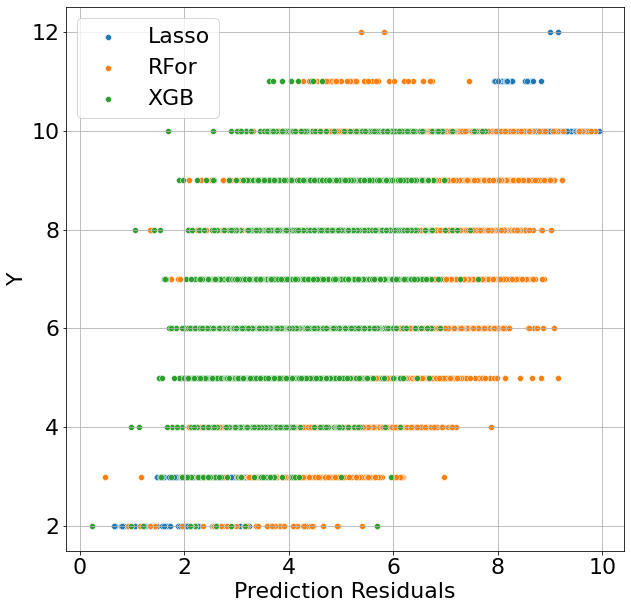

In [45]:
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(10,10))
sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_lasso,label='Lasso')
sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_rfor,label='RFor')
sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_xgb,label='XGB')
plt.xlabel('Prediction Residuals')
plt.ylabel('Y')
plt.grid()
#labels=[ 'Lasso','RFor','XGB']
plt.legend()

In [47]:
pd.DataFrame({'Y': y_lasso_test, 'Y_pred Lasso': final_y_pred_lasso, 'Y_pred RFor': final_y_pred_rfor, 'Y_pred XGB': final_y_pred_xgb}).corr()

,Y,Y_pred Lasso,Y_pred RFor,Y_pred XGB
Y,1.000000,0.452021,0.644483,0.687216
Y_pred Lasso,0.452021,1.000000,0.753644,0.764796
Y_pred RFor,0.644483,0.753644,1.000000,0.936672
Y_pred XGB,0.687216,0.764796,0.936672,1.000000


In [48]:
pd.DataFrame({'Y': y_lasso_test, 'Y_res Lasso': y_lasso_test-final_y_pred_lasso, 'Y_res RFor': y_lasso_test-final_y_pred_rfor, 'Y_res XGB': y_lasso_test-final_y_pred_xgb}).corr()

,Y,Y_res Lasso,Y_res RFor,Y_res XGB
Y,1.000000,0.888957,0.418957,0.493307
Y_res Lasso,0.888957,1.000000,0.654324,0.712991
Y_res RFor,0.418957,0.654324,1.000000,0.908152
Y_res XGB,0.493307,0.712991,0.908152,1.000000


Default XGBoost

In [53]:
#make first stage estimated values trained on 2020-2022 set for both lasso and xgb
xgbr_ldef.fit(x_train,y_train) # models fitted on train set
xgbr_rdef.fit(x_train,p_train)
y_pred_xgbdef=xgbr_ldef.predict(x_test)
p_pred_xgbdef=xgbr_rdef.predict(x_test)
#make final predictions based on estimated theta's and first stages
#use estimated theta's
theta_xgbdef= -0.033728
#final estimated demand:
final_y_pred_xgbdef=(p_test-p_pred_xgbdef)*(theta_xgbdef)+y_pred_xgbdef
#RMSE of models:
xgbrmsedef=mean_squared_error(final_y_pred_xgbdef, y_test,squared=False)
print("XGB RMSE on test dataset using estimated theta = ", xgbrmsedef, "\nXGB relative RMSE on yest dataset using estimated theta = ", xgbrmsedef/y_test.mean())

XGB RMSE on test dataset using estimated theta =  0.9648245007485511 
XGB relative RMSE on yest dataset using estimated theta =  0.13627718651693732


# Test on 2023 data

First prep the data set

In [54]:
df_test2023=pd.read_csv("dataframe_transformed_2023.csv")

In [55]:
df_test2023.shape

(22077, 56)

In [56]:
df_test2023.head()

,KEY_ARTICLE,KEY_WEEK,YEAR_CALENDAR_WEEK,WEEK_START_DATE,ARTICLE_NAME,PROMO_DUMMY,ARTICLE_ID,ART_CONTENT_VOLUME,ART_IS_MULTIPACK,product order amt,Avg sell price,Avg purchase price,AVG unavailability_perc,AVG_HIGH_TEMP,total order amt,NR_ARTICLES_IN_CAT,NR_ARTICLES_IN_CAT_2,product order amt_t-1,product order amt_t-2,Avg sell price_t-1,Avg sell price_t-2,ARTICLE_CAT_2_complete,PPL_postPPL2,PPL_postPPL3,ARTICLE_TIER_Better,ARTICLE_TIER_Good,ART_BRAND_TIER_Price entry,ART_BRAND_TIER_Private label,Packaging_Box,Packaging_Can,Packaging_Pack,ARTICLE_CAT_2_Drinkpakjes,ARTICLE_CAT_2_Fruitdrank,ARTICLE_CAT_2_IJsthee,ARTICLE_CAT_2_Limonade & siropen,ARTICLE_CAT_2_Sappen & smoothies,"ARTICLE_CAT_2_Sinas, Lemon & Cassis",ARTICLE_CAT_2_Speciaal fris,ARTICLE_CAT_2_Sport- & energydrink,ARTICLE_CAT_2_Water,DAYS_SINCE_START,WEEKS_SINCE_START,WEEK_NR,l_product order amt,l_Avg sell price,l_Avg purchase price,l_AVG_HIGH_TEMP,l_total order amt,l_NR_ARTICLES_IN_CAT,l_NR_ARTICLES_IN_CAT_2,l_product order amt_t-1,l_product order amt_t-2,l_Avg sell price_t-1,l_Avg sell price_t-2,l_WEEK_NR,l_AVG unavailability_perc
0,0019ba8f8c419ad55f1e8e7d8fec001f,202251,2022/51,2022-12-19,Cool Bear Siroop framboos appel 750ml,0,11402748,750.0,0,28.0,280.0,192.0,0.0,9.707857,179907,380,61,84.0,21.0,280.0,280.0,Limonade & siropen,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,721 days,103.0,104.0,3.332205,5.63479,5.257495,2.272936,12.100195,5.940171,4.110874,4.430817,3.044522,5.63479,5.63479,4.644391,-inf
1,0019ba8f8c419ad55f1e8e7d8fec001f,202251,2022/51,2022-12-19,Cool Bear Siroop framboos appel 750ml,0,11402748,750.0,0,28.0,280.0,192.0,0.0,9.707857,179907,380,61,84.0,21.0,280.0,280.0,Limonade & siropen,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,721 days,103.0,104.0,3.332205,5.63479,5.257495,2.272936,12.100195,5.940171,4.110874,4.430817,3.044522,5.63479,5.63479,4.644391,-inf
2,0019ba8f8c419ad55f1e8e7d8fec001f,202251,2022/51,2022-12-19,Cool Bear Siroop framboos appel 750ml,0,11402748,750.0,0,28.0,280.0,192.0,0.0,9.707857,179907,380,61,84.0,21.0,280.0,280.0,Limonade & siropen,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,721 days,103.0,104.0,3.332205,5.63479,5.257495,2.272936,12.100195,5.940171,4.110874,4.430817,3.044522,5.63479,5.63479,4.644391,-inf
3,0019ba8f8c419ad55f1e8e7d8fec001f,202251,2022/51,2022-12-19,Cool Bear Siroop framboos appel 750ml,0,11402748,750.0,0,231.0,280.0,192.0,0.0,9.707857,890491,380,61,343.0,35.0,280.0,280.0,Limonade & siropen,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,721 days,103.0,104.0,5.442418,5.63479,5.257495,2.272936,13.699528,5.940171,4.110874,5.837730,3.555348,5.63479,5.63479,4.644391,-inf
4,0019ba8f8c419ad55f1e8e7d8fec001f,202251,2022/51,2022-12-19,Cool Bear Siroop framboos appel 750ml,0,11402748,750.0,0,231.0,280.0,192.0,0.0,9.707857,890491,380,61,343.0,35.0,280.0,280.0,Limonade & siropen,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,721 days,103.0,104.0,5.442418,5.63479,5.257495,2.272936,13.699528,5.940171,4.110874,5.837730,3.555348,5.63479,5.63479,4.644391,-inf


In [57]:

# include dummy for holidays and other special dates that can explain irregular demand
listofHolidays=["2020-12-28",
                "2021-01-04",
                "2021-03-29",
                "2021-05-03",
                "2021-07-26",
                "2021-08-02",
                "2021-08-09",
                "2021-08-16",
                "2021-12-27",
                "2022-01-03",
                "2022-04-11",
                "2022-05-02",
                "2022-07-25",
                "2022-08-01",
                "2022-08-08",
                "2022-08-15",
                "2022-12-26"
                ]
df_test2023['HOLIDAY']=(df_test2023['WEEK_START_DATE'].isin(listofHolidays))*1
df_test2023=statsmodels.tools.tools.add_constant(df_test2023)

In [58]:
df_test2023[['PPL2','PPL3', 'POSTPPL1']]=0

In [59]:
renamedict={'const':'CONST',
'l_AVG_HIGH_TEMP':'L_AVG_HIGH_TEMP',
'l_NR_ARTICLES_IN_CAT':'L_NR_ARTICLES_IN_CAT', 
'l_NR_ARTICLES_IN_CAT_2':'L_NR_ARTICLES_IN_CAT_2',
# 'l_product order amt_t-1_m':'L_PRODUCT_ORDER_AMT_T_1_m',
# 'l_product order amt_t-2_m':'L_PRODUCT_ORDER_AMT_T_2_m',
'l_AVG unavailability_perc':'AVG_UNAVAILABILITY_PERC',
'PPL_postPPL2':'POSTPPL2',
'PPL_postPPL3':'POSTPPL3',
'ARTICLE_TIER_Better':'ARTICLE_TIER_BETTER',
'ARTICLE_TIER_Good':'ARTICLE_TIER_GOOD',
'ART_BRAND_TIER_Price entry':'ART_BRAND_TIER_PRICE_ENTRY',
'ART_BRAND_TIER_Private label':'ART_BRAND_TIER_PRIVATE_LABEL',
'Packaging_Box':'PACKAGING_BOX',
'Packaging_Can':'PACKAGING_CAN', 
'Packaging_Pack':'PACKAGING_PACK',
'ARTICLE_CAT_2_Drinkpakjes':'ARTICLE_CAT_2_DRINKPAKJES',
'ARTICLE_CAT_2_Fruitdrank':'ARTICLE_CAT_2_FRUITDRANK',
'ARTICLE_CAT_2_IJsthee':'ARTICLE_CAT_2_IJSTHEE',
'ARTICLE_CAT_2_Limonade & siropen':'ARTICLE_CAT_2_LIMONADE_SIROPEN',
'ARTICLE_CAT_2_Sappen & smoothies':'ARTICLE_CAT_2_SAPPEN_SMOOTHIES',
'ARTICLE_CAT_2_Sinas, Lemon & Cassis':'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
'ARTICLE_CAT_2_Speciaal fris':'ARTICLE_CAT_2_SPECIAAL_FRIS',
'ARTICLE_CAT_2_Sport- & energydrink':'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
'ARTICLE_CAT_2_Water':'ARTICLE_CAT_2_WATER',
'PROMO_DUMMY':'PROMO_DUMMY',
'WEEK_NR':'WEEK_NR', 
'ART_CONTENT_VOLUME':'ART_CONTENT_VOLUME', 
'ART_IS_MULTIPACK':'ART_IS_MULTIPACK',
'HOLIDAY':'HOLIDAY',
'l_product order amt': 'L_PRODUCT_ORDER_AMT',
'l_Avg sell price':'L_AVG_SELL_PRICE',
# 'l_product order amt_t-1':'L_PRODUCT_ORDER_AMT_T_1',
# 'l_product order amt_t-2':'L_PRODUCT_ORDER_AMT_T_2'
 }

In [60]:
df_test2023.rename(columns=renamedict,inplace=True)
df_test2023['AVG_UNAVAILABILITY_PERC'].replace([-np.inf], np.nan, inplace=True)
df_test2023['AVG_UNAVAILABILITY_PERC'] = df_test2023['AVG_UNAVAILABILITY_PERC'].fillna(0)

In [61]:
df_test2023.isin([-np.inf]).sum()

CONST                                  0
KEY_ARTICLE                            0
KEY_WEEK                               0
YEAR_CALENDAR_WEEK                     0
WEEK_START_DATE                        0
ARTICLE_NAME                           0
PROMO_DUMMY                            0
ARTICLE_ID                             0
ART_CONTENT_VOLUME                     0
ART_IS_MULTIPACK                       0
product order amt                      0
Avg sell price                         0
Avg purchase price                     0
AVG unavailability_perc                0
AVG_HIGH_TEMP                          0
total order amt                        0
NR_ARTICLES_IN_CAT                     0
NR_ARTICLES_IN_CAT_2                   0
product order amt_t-1                  0
product order amt_t-2                  0
Avg sell price_t-1                     0
Avg sell price_t-2                     0
ARTICLE_CAT_2_complete                 0
POSTPPL2                               0
POSTPPL3        

In [62]:
# lasso data sets are also used for RFOrest: no missing values

x_2023_lasso= df_test2023[['CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 
       'PROMO_DUMMY', 
       'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2','POSTPPL3', 
       'L_AVG_HIGH_TEMP',#'L_TOTAL_ORDER_AMT',
       'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2', # 'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       # 'L_PRODUCT_ORDER_AMT_T_2_m','L_PRODUCT_ORDER_AMT_T_1_m' ,
       # # 'L_PRODUCT_ORDER_AMT_T_1', 'L_PRODUCT_ORDER_AMT_T_2',
       #'L_AVG_PURCHASE_PRICE',
       'HOLIDAY','WEEK_NR'
       ]]
y_2023 = df_test2023['L_PRODUCT_ORDER_AMT']
p_2023 = df_test2023['L_AVG_SELL_PRICE']
# dmlset=x.join(y.to_frame().join(p.to_frame())) #needed in dml algortihm

y_lasso_2023 = y_2023.replace([-np.inf], np.nan)
y_lasso_2023 = y_lasso_2023.fillna(0)


#xgboost can handle missing values np.nan (instead of -inf): 
df_test2023.replace([-np.inf], np.nan, inplace=True)

x_2023_xgb= df_test2023[['CONST','ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD',
       'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL',
       'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK',
       'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK',
       'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN',
       'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS',
       'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK',
       'ARTICLE_CAT_2_WATER', 
       'PROMO_DUMMY', 
       'PPL2','PPL3', 'POSTPPL1', 'POSTPPL2','POSTPPL3', 
       'L_AVG_HIGH_TEMP',#'L_TOTAL_ORDER_AMT',
       'L_NR_ARTICLES_IN_CAT', 
       'L_NR_ARTICLES_IN_CAT_2',  #'L_WEEK_NR',
       'AVG_UNAVAILABILITY_PERC',
       'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 
       # # 'L_PRODUCT_ORDER_AMT_T_2_m','L_PRODUCT_ORDER_AMT_T_1_m' 
       # 'L_PRODUCT_ORDER_AMT_T_1', 'L_PRODUCT_ORDER_AMT_T_2',
       #'L_AVG_PURCHASE_PRICE' # not an instrument anymore,
       'HOLIDAY', 'WEEK_NR'
       ]]

In [63]:
y_lasso_2023.isin([np.inf]).sum()

0

# 2023 predictions and results

Following the model, the prediction is made as follows: <br>
y_pred-l(X)=(p-(m(X))*theta<br>
y_pred = (P-m(X))*theta+l(X)<br>
so make rmse with this y_pred

In [64]:
#make first stage estimated values trained on 2020-2022 set for both lasso and xgb
y_pred_2023_lasso=ml_l_tune.predict(x_2023_lasso)
p_pred_2023_lasso=ml_r_tune.predict(x_2023_lasso)
y_pred_2023_rfor=rfor_l.predict(x_2023_lasso)
p_pred_2023_rfor=rfor_r.predict(x_2023_lasso)
y_pred_2023_xgb=grid_searchi.predict(x_2023_xgb)
p_pred_2023_xgb=grid_searchii.predict(x_2023_xgb)

In [65]:
#make final predictions based on estimated theta's and first stages
#use estimated theta's
theta_lasso=
theta_rfor=
theta_xgb=
#final estimated demand:
final_y_pred_2023_lasso=(p_2023)*(theta_lasso)+y_pred_2023_lasso
final_y_pred_2023_rfor=(p_2023)*(theta_rfor)+y_pred_2023_rfor
final_y_pred_2023_xgb=(p_2023)*(theta_xgb)+y_pred_2023_xgb
#RMSE of models:
lasso2023rmse=mean_squared_error(final_y_pred_2023_lasso,y_lasso_2023,squared=True)
rfor2023rmse=mean_squared_error(final_y_pred_2023_rfor,y_lasso_2023,squared=True)
xgb2023rmse=mean_squared_error(final_y_pred_2023_xgb, y_lasso_2023,squared=True) # not y_2023 because for RMSE cannot work with NaNs
print("Lasso RMSE on 2023 dataset using estimated theta = ", lasso2023rmse, "\nLasso relative RMSE on 2023 dataset using estimated theta = ", lasso2023rmse/y_lasso_2023.mean())
print("Rfor RMSE on 2023 dataset using estimated theta = ", rfor2023rmse, "\nRfor relative RMSE on 2023 dataset using estimated theta = ", rfor2023rmse/y_lasso_2023.mean())
print("XGB RMSE on 2023 dataset using estimated theta = ", xgb2023rmse, "\nXGB relative RMSE on 2023 dataset using estimated theta = ", xgb2023rmse/y_lasso_2023.mean())

Lasso RMSE on 2023 dataset using estimated theta =  34.6082969682982 
Lasso relative RMSE on 2023 dataset using estimated theta =  5.401617565290913
Rfor RMSE on 2023 dataset using estimated theta =  30.26100649629192 
Rfor relative RMSE on 2023 dataset using estimated theta =  4.723098174506639
XGB RMSE on 2023 dataset using estimated theta =  17.555408123879428 
XGB relative RMSE on 2023 dataset using estimated theta =  2.7400250574208154


In [66]:
# fig, ax =plt.subplots(1,2,figsize=(20, 10))
# sns.regplot(y=y_lasso_2023,x=final_y_pred_2023_lasso,ax=ax[0],label='Lasso')
# sns.regplot(y=y_lasso_2023,x=final_y_pred_2023_rfor,ax=ax[0],label='RFor')
# sns.regplot(y=y_lasso_2023,x=final_y_pred_2023_xgb,ax=ax[0],label='XGB')
# ax[0].set_xlabel('Y Prediction')
# ax[0].set_ylabel('Y')
# ax[0].grid()
# sns.regplot(y=y_lasso_2023,x=y_lasso_2023-final_y_pred_2023_lasso,ax=ax[1])
# sns.regplot(y=y_lasso_2023,x=y_lasso_2023-final_y_pred_2023_rfor,ax=ax[1])
# sns.regplot(y=y_lasso_2023,x=y_lasso_2023-final_y_pred_2023_xgb,ax=ax[1])
# ax[1].set_xlabel('Y Prediction')
# ax[1].set_ylabel('Y')
# ax[1].grid()
# fig.legend()
# fig.suptitle('Final prediction Y')
# fig.show()

C:\Users\Florence Piet\AppData\Local\Temp\ipykernel_10684\4080740089.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


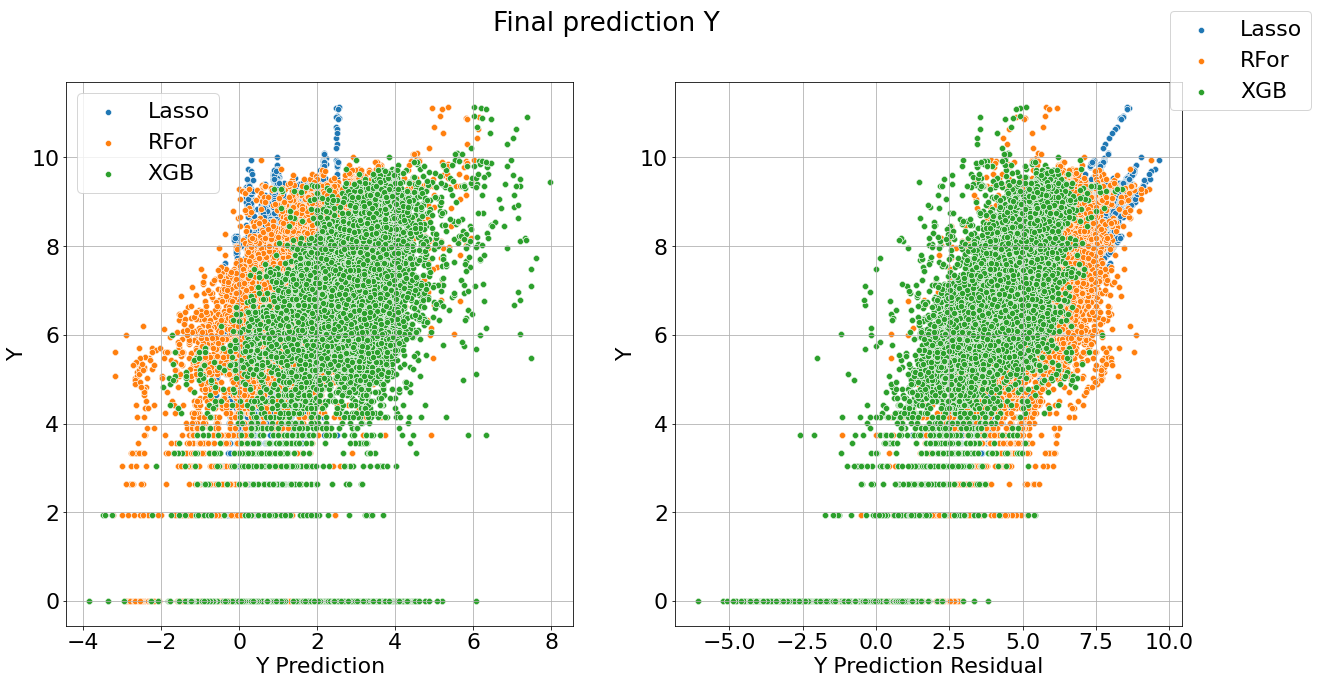

In [67]:
fig, ax =plt.subplots(1,2,figsize=(20, 10))
sns.scatterplot(y=y_lasso_2023,x=final_y_pred_2023_lasso,ax=ax[0],label='Lasso')
sns.scatterplot(y=y_lasso_2023,x=final_y_pred_2023_rfor,ax=ax[0],label='RFor')
sns.scatterplot(y=y_lasso_2023,x=final_y_pred_2023_xgb,ax=ax[0],label='XGB')
ax[0].set_xlabel('Y Prediction')
ax[0].set_ylabel('Y')
ax[0].grid()
sns.scatterplot(y=y_lasso_2023,x=y_lasso_2023-final_y_pred_2023_lasso,ax=ax[1])
sns.scatterplot(y=y_lasso_2023,x=y_lasso_2023-final_y_pred_2023_rfor,ax=ax[1])
sns.scatterplot(y=y_lasso_2023,x=y_lasso_2023-final_y_pred_2023_xgb,ax=ax[1])
ax[1].set_xlabel('Y Prediction Residual')
ax[1].set_ylabel('Y')
ax[1].grid()
fig.legend()
fig.suptitle('Final prediction Y')
fig.show()

In [68]:
pd.DataFrame({'Y': y_2023, 'Y_pred Lasso': final_y_pred_2023_lasso, 'Y_pred RFor': final_y_pred_2023_rfor, 'Y_pred XGB': final_y_pred_2023_xgb}).corr()

,Y,Y_pred Lasso,Y_pred RFor,Y_pred XGB
Y,1.000000,0.351536,0.526185,0.504194
Y_pred Lasso,0.351536,1.000000,0.772426,0.742081
Y_pred RFor,0.526185,0.772426,1.000000,0.948899
Y_pred XGB,0.504194,0.742081,0.948899,1.000000


In [69]:
pd.DataFrame({'Y': y_2023, 'Y res Lasso': y_2023-final_y_pred_2023_lasso, 'Y res RFor': y_2023-final_y_pred_2023_rfor, 'Y res XGB': y_2023-final_y_pred_2023_xgb}).corr()

,Y,Y res Lasso,Y res RFor,Y res XGB
Y,1.000000,0.927354,0.625785,0.641061
Y res Lasso,0.927354,1.000000,0.791177,0.791674
Y res RFor,0.625785,0.791177,1.000000,0.957012
Y res XGB,0.641061,0.791674,0.957012,1.000000


# Model Variation: Simple model for Price

In [83]:
# xgbr_l= grid_searchi.best_estimator_
# xgbr_l=xgb.XGBRegressor(**paramsl)
# xgbr_m = grid_searchii.best_estimator_ # voor m gebruik optimized Lasso
obj_dml_data = dml.DoubleMLData(dmlset_lasso_train, 'L_PRODUCT_ORDER_AMT', 'L_AVG_SELL_PRICE',force_all_x_finite='allow-nan')
dml_pliv_obj = dml.DoubleMLPLR(obj_dml_data, xgbr_l, ml_r_tune)
print(dml_pliv_obj.fit())

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: L_PRODUCT_ORDER_AMT
Treatment variable(s): ['L_AVG_SELL_PRICE']
Covariates: ['CONST', 'ARTICLE_TIER_BETTER', 'ARTICLE_TIER_GOOD', 'ART_BRAND_TIER_PRICE_ENTRY', 'ART_BRAND_TIER_PRIVATE_LABEL', 'PACKAGING_BOX', 'PACKAGING_CAN', 'PACKAGING_PACK', 'ARTICLE_CAT_2_DRINKPAKJES', 'ARTICLE_CAT_2_FRUITDRANK', 'ARTICLE_CAT_2_IJSTHEE', 'ARTICLE_CAT_2_LIMONADE_SIROPEN', 'ARTICLE_CAT_2_SAPPEN_SMOOTHIES', 'ARTICLE_CAT_2_SINAS_LEMON_CASSIS', 'ARTICLE_CAT_2_SPECIAAL_FRIS', 'ARTICLE_CAT_2_SPORT_ENERGYDRINK', 'ARTICLE_CAT_2_WATER', 'PROMO_DUMMY', 'PPL2', 'PPL3', 'POSTPPL1', 'POSTPPL2', 'POSTPPL3', 'L_AVG_HIGH_TEMP', 'L_NR_ARTICLES_IN_CAT', 'L_NR_ARTICLES_IN_CAT_2', 'AVG_UNAVAILABILITY_PERC', 'ART_CONTENT_VOLUME', 'ART_IS_MULTIPACK', 'HOLIDAY', 'WEEK_NR']
Instrument variable(s): None
No. Observations: 50933

------------------ Score & algorithm ------------------
Score functi

In [84]:
xgbr_l_fit=xgbr_l.fit(x_lasso_train,y_lasso_train)
y_pred_xgb=xgbr_l_fit.predict(x_lasso_test)
#use estimated theta's
theta_modelvar=-0.063204
#final estimated demand:
final_y_pred_modelvar_test=(p_lasso_test)*(theta_modelvar)+y_pred_xgb
#RMSE of models:
modvarrmse=mean_squared_error(final_y_pred_modelvar_test,y_lasso_test,squared=False)

print("XGB RMSE on test dataset using estimated theta = ", modvarrmse, "\nXGB relative RMSE on yest dataset using estimated theta = ", modvarrmse/y_lasso_test.mean())

XGB RMSE on test dataset using estimated theta =  1.0061070744248002 
XGB relative RMSE on yest dataset using estimated theta =  0.141992401575929


In [85]:
xgbr_l_fit=xgbr_l.fit(x_lasso_train,y_lasso_train)
y_pred_xgb=xgbr_l_fit.predict(x_lasso_train)
#use estimated theta's
theta_modelvar=-0.063204 
#final estimated demand:
final_y_pred_modelvar_train=(p_lasso_train)*(theta_modelvar)+y_pred_xgb
#RMSE of models:
modvarrmse=mean_squared_error(final_y_pred_modelvar_train,y_lasso_train,squared=False)

print("XGB/Lasso RMSE on train dataset using estimated theta = ", modvarrmse, "\nXGB relative RMSE on yest dataset using estimated theta = ", modvarrmse/y_lasso_test.mean())

XGB/Lasso RMSE on train dataset using estimated theta =  0.8894847372863037 
XGB relative RMSE on yest dataset using estimated theta =  0.12553343200038958


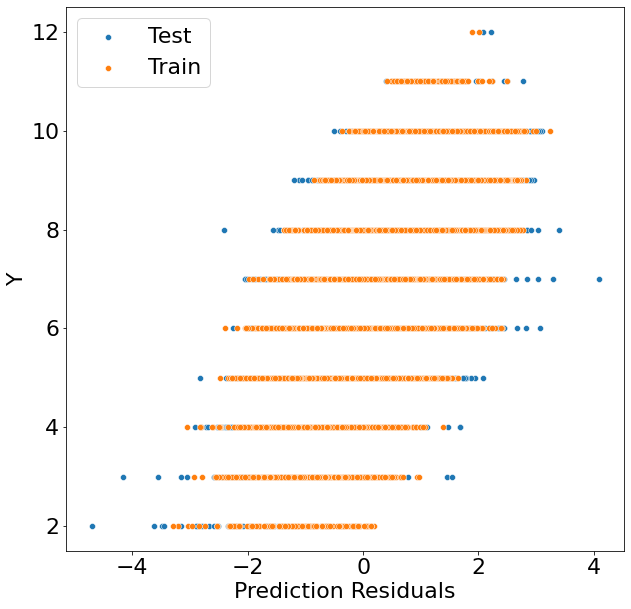

In [86]:
plt.figure(figsize=(10,10))
sns.scatterplot(y=y_lasso_test,x=y_lasso_test-final_y_pred_modelvar_test,label='Test')
sns.scatterplot(y=y_lasso_train,x=y_lasso_train-final_y_pred_modelvar_train,label='Train')
plt.xlabel('Prediction Residuals')
plt.ylabel('Y')

plt.legend()

In [87]:
pd.DataFrame({'Y test': y_lasso_test, 'Y_res test': y_lasso_test-final_y_pred_modelvar_test, 'Y Train': y_lasso_train, 'Y_res train': y_lasso_train-final_y_pred_modelvar_train}).corr()

,Y test,Y_res test,Y Train,Y_res train
Y test,1.000000,0.675113,NaN,NaN
Y_res test,0.675113,1.000000,NaN,NaN
Y Train,NaN,NaN,1.000000,0.674553
Y_res train,NaN,NaN,0.674553,1.000000


# Optional: Feature importances in the first stage model of demand: 
(price is left out in this model - so it won't make total sense, but it gives an indication)

This gives insights in most important variables of l(X) (price is left out in this model - so it won't make total sense, but it gives an indication)

This is the same as in PLIV - first stage is the same in PLR and PLIV

In [88]:
ml_l_tune.fit(x_lasso_train,y_lasso_train)
rfor_l.fit(x_lasso_train,y_lasso_train)
xgbr_l.fit(x_lasso_train,y_lasso_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

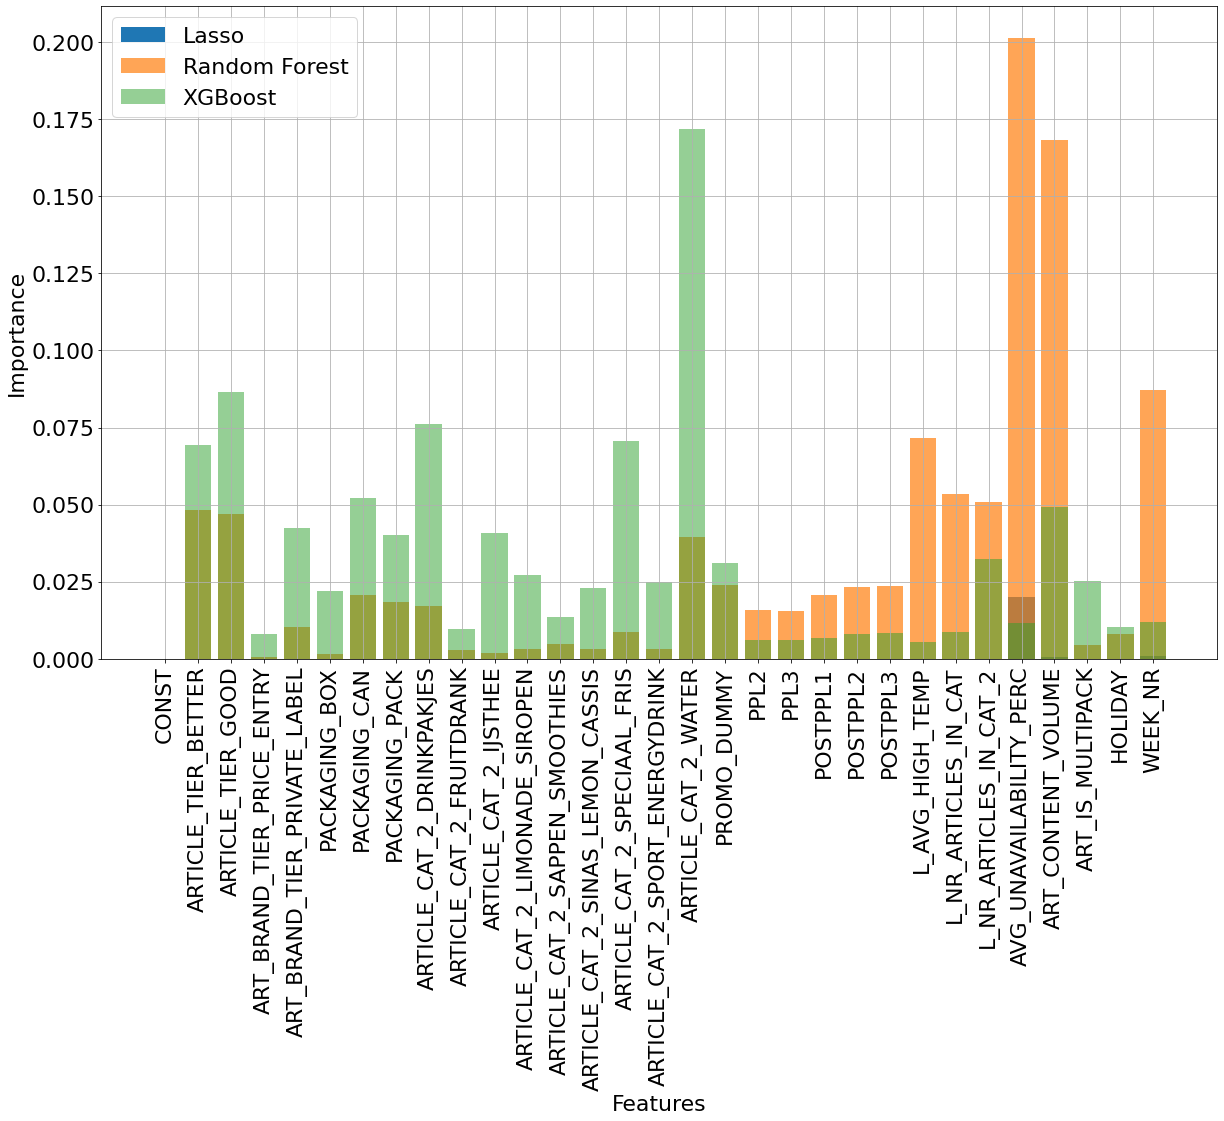

In [89]:
lasso_importance = np.abs(ml_l_tune.coef_)
rf_importance = rfor_l.feature_importances_
xgb_importance = xgbr_l.feature_importances_

# Plot the feature importances
plt.figure(figsize=(20, 12))
plt.bar(x_lasso_train.columns, lasso_importance, label='Lasso')
plt.bar(x_lasso_train.columns, rf_importance, alpha=0.7, label='Random Forest')
plt.bar(x_lasso_train.columns, xgb_importance, alpha=0.5, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.grid()
plt.show()


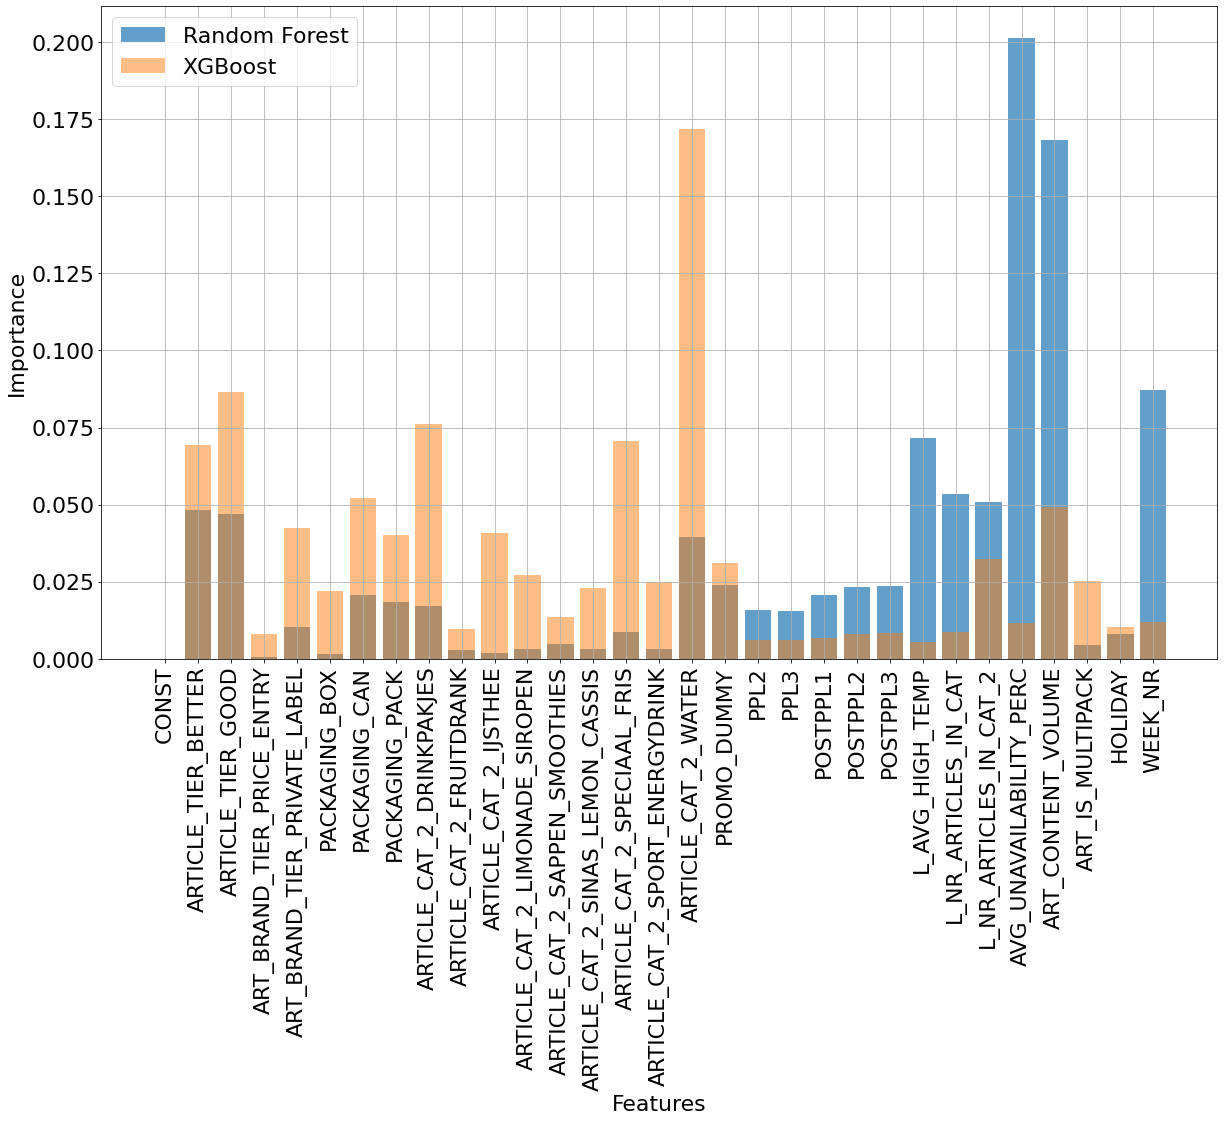

In [90]:
#using normalized feature importances:
lasso_importance = np.abs(ml_l_tune.coef_)/np.sum(np.abs(ml_l_tune.coef_))
rf_importance = rfor_l.feature_importances_/np.sum(rfor_l.feature_importances_)
xgb_importance = xgbr_l.feature_importances_/np.sum(xgbr_l.feature_importances_)

# Plot the feature importances
plt.figure(figsize=(20, 12))
# plt.bar(x_lasso_train.columns, lasso_importance, label='Lasso')
plt.bar(x_lasso_train.columns, rf_importance, alpha=0.7, label='Random Forest')
plt.bar(x_lasso_train.columns, xgb_importance, alpha=0.5, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.grid()
plt.show()


Numerical:

In [91]:
# ml_l_tune.fit(x_lasso_train,y_lasso_train)
# rfor_l.fit(x_lasso_train,y_lasso_train)
# xgbr_l.fit(x_lasso_train,y_lasso_train)

# # Get the feature importances for each model
# lasso_importance = np.abs(ml_l_tune.coef_)
# rf_importance = rfor_l.feature_importances_
# xgb_importance = xgbr_l.feature_importances_

feature_names=x_lasso_train.columns

# Print the feature importances for each model
print("LassoCV feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {lasso_importance[i]}")
print("\nRandom Forest feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {rf_importance[i]}")
print("\nXGBoost feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {xgb_importance[i]}")


LassoCV feature importances:
CONST: 0.0
ARTICLE_TIER_BETTER: 0.0
ARTICLE_TIER_GOOD: 0.0
ART_BRAND_TIER_PRICE_ENTRY: 0.0
ART_BRAND_TIER_PRIVATE_LABEL: 0.0
PACKAGING_BOX: 0.0
PACKAGING_CAN: 0.0
PACKAGING_PACK: 0.0
ARTICLE_CAT_2_DRINKPAKJES: 0.0
ARTICLE_CAT_2_FRUITDRANK: 0.0
ARTICLE_CAT_2_IJSTHEE: 0.0
ARTICLE_CAT_2_LIMONADE_SIROPEN: 0.0
ARTICLE_CAT_2_SAPPEN_SMOOTHIES: 0.0
ARTICLE_CAT_2_SINAS_LEMON_CASSIS: 0.0
ARTICLE_CAT_2_SPECIAAL_FRIS: 0.0
ARTICLE_CAT_2_SPORT_ENERGYDRINK: 0.0
ARTICLE_CAT_2_WATER: 0.0
PROMO_DUMMY: 0.0
PPL2: 0.0
PPL3: 0.0
POSTPPL1: 0.0
POSTPPL2: 0.0
POSTPPL3: 0.0
L_AVG_HIGH_TEMP: 0.0
L_NR_ARTICLES_IN_CAT: 0.0
L_NR_ARTICLES_IN_CAT_2: 0.0
AVG_UNAVAILABILITY_PERC: 0.9380672531405091
ART_CONTENT_VOLUME: 0.021338997162979788
ART_IS_MULTIPACK: 0.0
HOLIDAY: 0.0
WEEK_NR: 0.040593749696511035

Random Forest feature importances:
CONST: 0.0
ARTICLE_TIER_BETTER: 0.04825752591924942
ARTICLE_TIER_GOOD: 0.04711902139238507
ART_BRAND_TIER_PRICE_ENTRY: 0.0007153240278117973
ART_BRAND_TIER

For price:

In [92]:
ml_r_tune.fit(x_lasso_train,p_lasso_train)
rfor_r.fit(x_lasso_train,p_lasso_train)
xgbr_r.fit(x_lasso_train,p_lasso_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

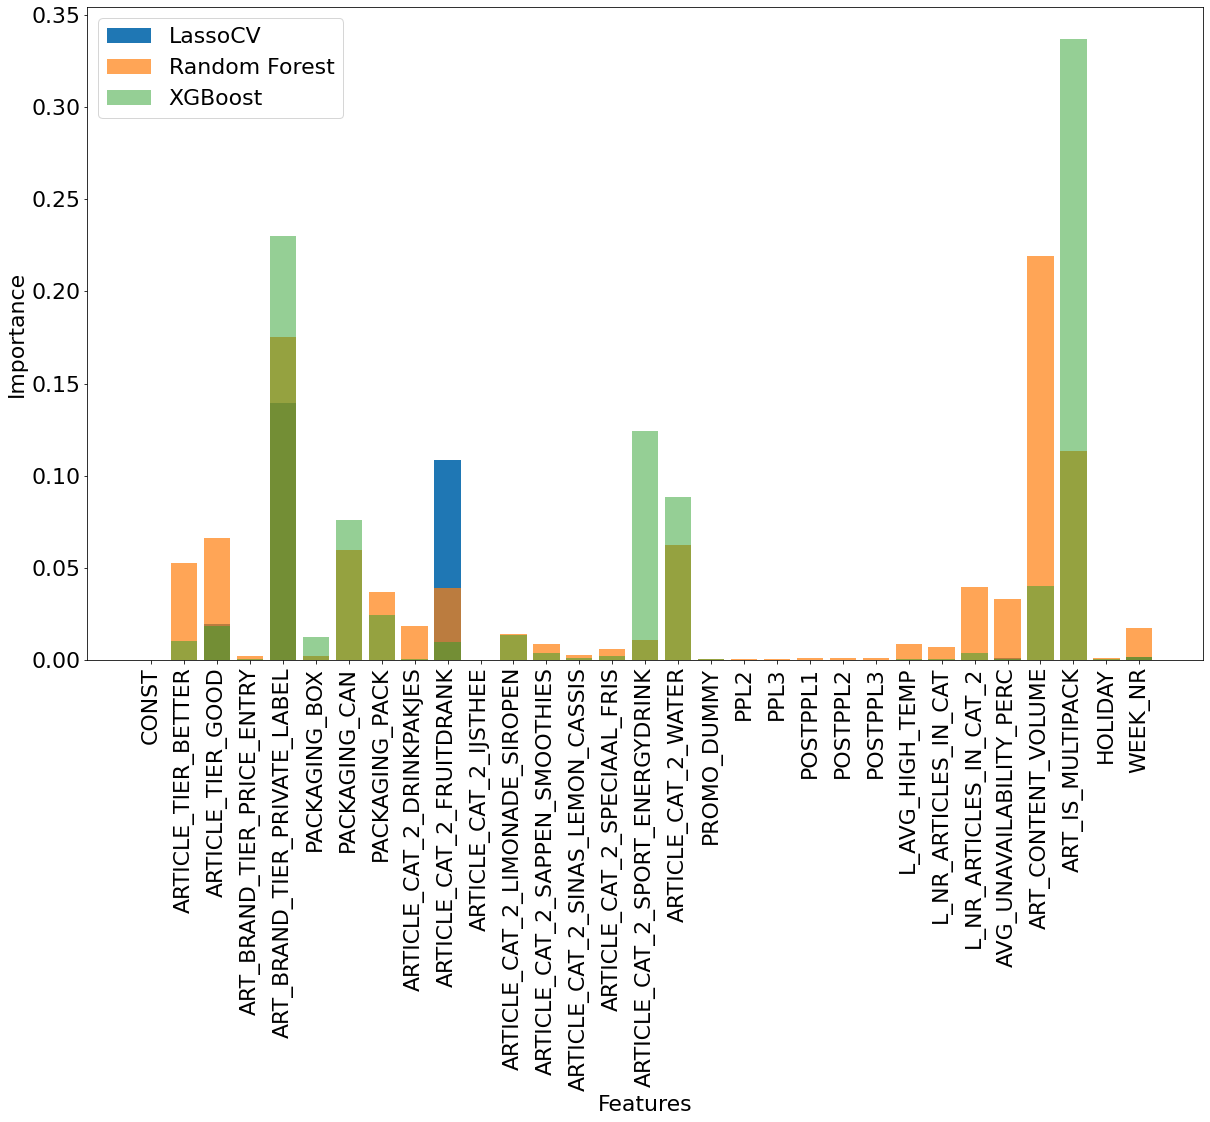

In [93]:
lasso_importance = np.abs(ml_r_tune.coef_)
rf_importance = rfor_r.feature_importances_
xgb_importance = xgbr_r.feature_importances_

# Plot the feature importances
plt.figure(figsize=(20, 12))
plt.bar(x_lasso_train.columns, lasso_importance, label='LassoCV')
plt.bar(x_lasso_train.columns, rf_importance, alpha=0.7, label='Random Forest')
plt.bar(x_lasso_train.columns, xgb_importance, alpha=0.5, label='XGBoost')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.show()


In [94]:
# ml_r_tune.fit(x_lasso_train,p_lasso_train)
# rfor_r.fit(x_lasso_train,p_lasso_train)
# xgbr_r.fit(x_lasso_train,p_lasso_train)

# # Get the feature importances for each model
# lasso_importance = np.abs(ml_r_tune.coef_)
# rf_importance = rfor_r.feature_importances_
# xgb_importance = xgbr_r.feature_importances_

feature_names=x_lasso_train.columns

# Print the feature importances for each model
print("LassoCV feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {lasso_importance[i]}")
print("\nRandom Forest feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {rf_importance[i]}")
print("\nXGBoost feature importances:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {xgb_importance[i]}")


LassoCV feature importances:
CONST: 0.0
ARTICLE_TIER_BETTER: 0.0
ARTICLE_TIER_GOOD: 0.019330146310645096
ART_BRAND_TIER_PRICE_ENTRY: 0.0
ART_BRAND_TIER_PRIVATE_LABEL: 0.1394520315251469
PACKAGING_BOX: 0.0
PACKAGING_CAN: 0.0
PACKAGING_PACK: 0.0
ARTICLE_CAT_2_DRINKPAKJES: 0.0
ARTICLE_CAT_2_FRUITDRANK: 0.10865425032298644
ARTICLE_CAT_2_IJSTHEE: 0.0
ARTICLE_CAT_2_LIMONADE_SIROPEN: 0.0
ARTICLE_CAT_2_SAPPEN_SMOOTHIES: 0.0
ARTICLE_CAT_2_SINAS_LEMON_CASSIS: 0.0
ARTICLE_CAT_2_SPECIAAL_FRIS: 0.0
ARTICLE_CAT_2_SPORT_ENERGYDRINK: 0.0
ARTICLE_CAT_2_WATER: 0.0
PROMO_DUMMY: 0.0
PPL2: 0.0
PPL3: 0.0
POSTPPL1: 0.0
POSTPPL2: 0.0
POSTPPL3: 0.0
L_AVG_HIGH_TEMP: 0.0
L_NR_ARTICLES_IN_CAT: 0.0
L_NR_ARTICLES_IN_CAT_2: 0.0
AVG_UNAVAILABILITY_PERC: 0.0011533789230875017
ART_CONTENT_VOLUME: 0.00014526773854464843
ART_IS_MULTIPACK: 0.0
HOLIDAY: 0.0
WEEK_NR: 0.0013373878653845065

Random Forest feature importances:
CONST: 0.0
ARTICLE_TIER_BETTER: 0.05267279032768209
ARTICLE_TIER_GOOD: 0.06614429939838663
ART_BRAND_